In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
from PIL import Image
class Resize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, img):
        return img.resize((self.width, self.height), Image.BICUBIC)

In [4]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

# загрузка датасета

In [5]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [6]:
N = 14
NUM_CLASSES = 10
SEED = 42
BATCH_SIZE = 1

In [7]:
transforms = torchvision.transforms.Compose([
    Resize(N, N),
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [8]:
train_dataset = datasets.MNIST(root='data', train=True, download=False, transform=transforms)
test_dataset = datasets.MNIST(root='data', train=False, download=False, transform=transforms)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
for img, label in train_loader:
    break

4


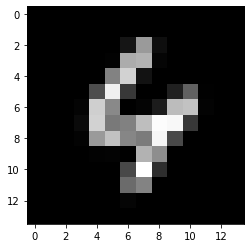

In [13]:
imshow(img.reshape(N, N), label=label[0].item())

# функции активации

In [27]:
x = np.linspace(-5, 5, 100)

### сигмоида

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

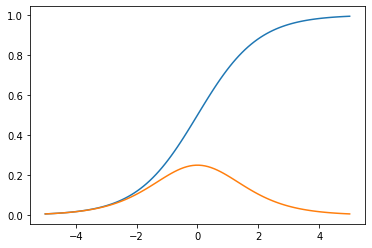

In [29]:
plt.plot(x, sigmoid(x))
plt.plot(x, d_sigmoid(x))

### гиперболический тангенс

In [15]:
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def d_tanh(x):
    return 1 - tanh(x)**2

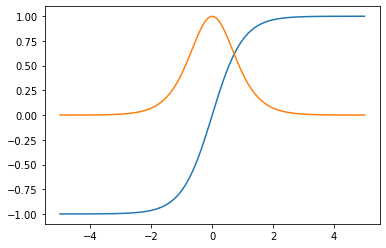

In [30]:
plt.plot(x, tanh(x))
plt.plot(x, d_tanh(x))

### линейный выпрямитель

In [16]:
def ReLU(x):
    return x * (x > 0)

def d_ReLU(x):
    return 1. * (x > 0)

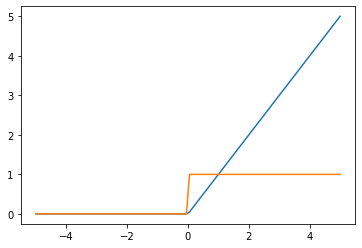

In [31]:
plt.plot(x, ReLU(x))
plt.plot(x, d_ReLU(x))

# функции потерь

## среднеквадратичная ошибка

In [39]:
def mse_cost(pred, y) -> float:
    return (1/2 * np.square(pred-y)).mean()

def d_mse_cost(pred, y) -> np.array:
    return (pred-y)

In [41]:
class NN():
    def __init__(self, sizes=[N*N, 10], activation='sigmoid', cost='mse'):
        np.random.seed(SEED)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.num_classes = sizes[-1]
        self.w = np.random.uniform(-1, 1, size=(N*N, self.num_classes))
        self.b = np.random.uniform(-1, 1, size=(self.num_classes,))
        self.biases = [
            np.random.uniform(-1, 1, size=(s_in,)) for s_in in sizes[1:]
        ]
        
        self.weights = [
            np.random.uniform(
                low=-1., high=1., size=(in_s, out_s)
            )
            for in_s, out_s in zip(sizes[:-1], sizes[1:])
        ]
        self.set_activation(activation)
        self.set_cost(cost)
    
    def set_activation(self, name='sigmoid'):
        if name == 'sigmoid':
            self.activation = sigmoid
            self.d_activation = d_sigmoid
        elif name == 'tanh':
            self.activation = tanh
            self.d_activation = d_tanh
        elif name == 'relu':
            self.activation = ReLU
            self.d_activation = d_ReLU
        else:
            raise('no such activation')
    
    def set_cost(self, name='mse'):
        if name == 'mse':
            self.cost = mse_cost
            self.d_cost = d_mse_cost
#         elif name == 'ce':
#             pass
        else:
            raise('no such cost')

    def forward_collect(self, x):
        zs = []
        activations = [x]
        for b, w in zip(self.biases, self.weights):
            z = np.dot(x, w) + b
            x = self.activation(z)
            zs.append(z)
            activations.append(x)
        return zs, activations
    
    def one_hot(self, label):
        return F.one_hot(label, self.num_classes)
    
    def backward(self, zs, activations, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        last_a = activations[-1]
        prev_last_a = activations[-2]
        last_z = zs[-1]
        
        dcost = self.d_cost(last_a, y) * self.d_activation(last_z)
    
        nabla_w[-1] = np.dot(dcost.T, prev_last_a).T
        nabla_b[-1] = np.sum(dcost, axis=0)
        
        for i in range(2, self.num_layers):
            z = zs[-i]
            prev_a = activations[-i-1]
            dcost = np.dot(self.weights[-i+1], dcost.T).T * self.d_activation(z)
            nabla_w[-i] = np.dot(dcost.T, prev_a).T
            nabla_b[-i] = np.sum(dcost, axis=0)
            
        return nabla_w, nabla_b
    
    def train(self, loader, lr=1e-2, num_samples=1000):
        samples = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label).numpy()
            x = img.numpy()
            
            zs, activations = self.forward_collect(x)
            nabla_w, nabla_b = self.backward(zs, activations, y)
            
            for i, d in enumerate(zip(nabla_w, nabla_b)):
                dw, db = d
                self.weights[i] -= lr * dw
                self.biases[i] -= lr * db
            samples += 1
            if samples == num_samples:
                break

    def predict(self, imgs):
        x = imgs
        pred = self.forward_collect(x)[1][-1]
        label = np.argmax(np.array(pred), axis=1)
        return label

    def testing(self, loader, num_samples=1000):
        acc = 0
        counter = 0
        all_labels = []
        all_preds = []
        losses = []
        samples = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label).numpy()
            x = img.numpy()
            pred = self.forward_collect(x)[1][-1]
            loss = np.mean(self.cost(pred, y))
            losses.append(loss)
            preds = np.argmax(np.array(pred), axis=1)
            labels = label.numpy()
            
            acc += sum(labels == preds)
            counter += bs
            
            all_labels.extend(labels)
            all_preds.extend(preds)
            
            samples += 1
            if samples == num_samples:
                break
                
        return acc / counter, np.mean(losses), all_labels, all_preds 
            

In [42]:
BATCH_SIZE = 64

In [43]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [44]:
EPOCHS = 100
NUM_SAMPLES = 100 # number of batches
VAL_NUM_SAMPLES = 10 # number of batches
LR = 0.001

In [45]:
ACTIVATIONS = ['sigmoid', 'relu', 'tanh']

In [46]:
acc_map = dict()
loss_map = dict()

for a_name in ACTIVATIONS:
    acc_map[a_name] = []
    loss_map[a_name] = []
    
    nn = NN([N*N, 64, NUM_CLASSES], a_name)
    
    print(f'start train for {a_name}')
    
    for i in tqdm(range(EPOCHS)):
        nn.train(train_loader, lr=LR, num_samples=NUM_SAMPLES)
        acc, loss, labels, preds = nn.testing(test_loader, num_samples=VAL_NUM_SAMPLES)
        acc_map[a_name].append(acc)
        loss_map[a_name].append(loss)

    print(f'end train for {a_name}')

start train for sigmoid


  0%|          | 0/100 [00:00<?, ?it/s]

end train for sigmoid
start train for relu


  0%|          | 0/100 [00:00<?, ?it/s]

end train for relu
start train for tanh


  0%|          | 0/100 [00:00<?, ?it/s]

end train for tanh


In [ ]:
for ax in axs.flat:
    ax.label_outer()

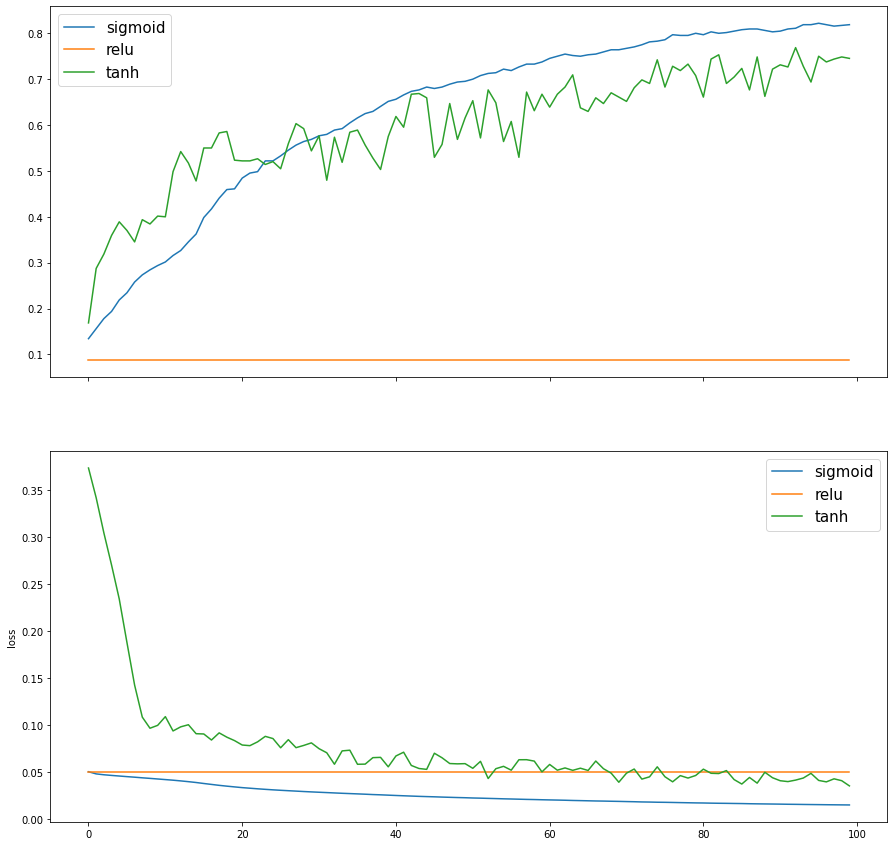

In [66]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
for name in ACTIVATIONS:
    axs[0].plot(acc_map[name])
    axs[0].legend(ACTIVATIONS, prop={'size': 15})
    axs[1].plot(loss_map[name])
    axs[1].set(ylabel='loss')
    axs[1].legend(ACTIVATIONS, prop={'size': 15})
for ax in axs.flat:
    ax.label_outer()

pred: 6
gt: 5


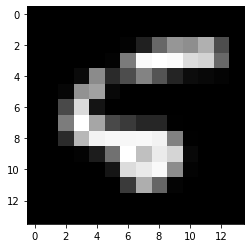

pred: 8
gt: 6


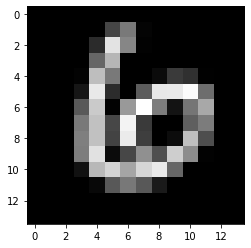

pred: 3
gt: 5


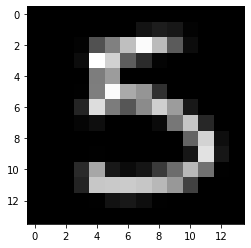

pred: 5
gt: 4


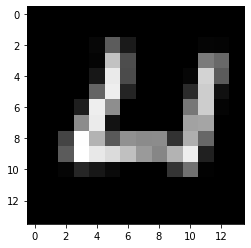

pred: 3
gt: 2


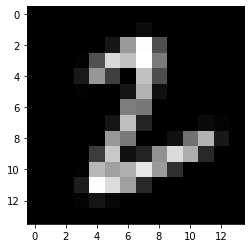

pred: 8
gt: 2


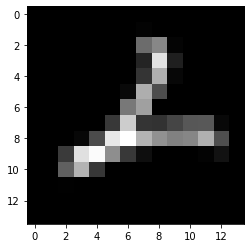

pred: 3
gt: 5


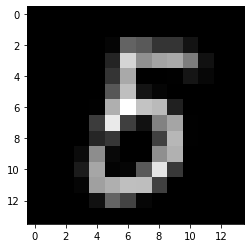

pred: 3
gt: 5


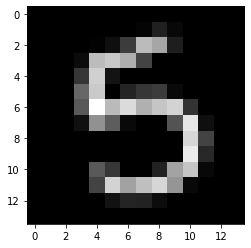

pred: 8
gt: 0


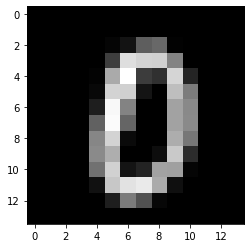

pred: 7
gt: 5


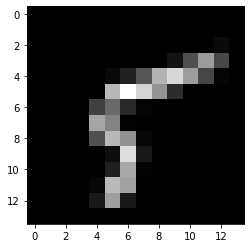

In [51]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
stop = 10
for img, label in test_loader:
    x = img.numpy()
    label = label[0].numpy()
    pred = nn.predict(x)[0]
    
    if pred != label:
        imshow(x.reshape(N, N), f'pred: {pred}\ngt: {label}')
        stop -= 1

        
    if stop == 0:
        break

### кросс-энтропия

In [52]:
def cross_entropy(X,y):
    X = X.clip(min=1e-8, max=None)
    return (np.where(y==1,-np.log(X), 0)).sum(axis=1)

def cross_entropy_derivative(X,y):
    X = X.clip(min=1e-8, max=None)
    return np.where(y==1,-1/X, 0)

In [ ]:
def softmax(x):
    y = np.exp(x)
    return y / np.sum(y)

def cross_entropy_loss(y, pred):
    bs = y.shape[0]
    return -np.sum(y * np.log(pred)) / bs